<a href="https://colab.research.google.com/github/sflyranger/finetuning-encoder-decoder-models-sequence-classification/blob/main/QWEN_2_5_1_5B_multilabel_emotion_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'red'>**Multilabel Generation with QWEN.2.5-1.5B**

The purpose of this notebook is to finetune the **QWEN** model for emotion detection on a small dataset.

- Based on my past experiences using both RNN and BERT models, I plan on using a similar strategy to account for the class imbalance present in this dataset.

- This will be done using **K-fold stratified sampling** to create my splits such that the class distribution represents that of the training set.

- Instead of modifying the architecture by replacing the language head with a classification head, I will **retain the language head** of the instruction-tuned model and use it to generate the emotion labels directly.

- The training will follow a standard model training process as shown below.

---

## <font color = 'red'>**Training Plan**

1. **Set the Environment**

2. **Load the Dataset**

3. **Manipulate the Splits of the Dataset**
   - Use stratified K-fold sampling to maintain class balance in splits.

4. **Load the Pretrained Tokenizer**

5. **Create a Function for the Tokenizer**
  - 5.1 Filtering Long Sequences
  - 5.2 Data Collator

6. **Train the Model**
   - 6.1. Download the model
   - 6.2. PEFT Setup
   - 6.3. Define Training Arguments
   - 6.4. Instantiate the Trainer
   - 6.5. Setup Weights & Biases (WANDB)
   - 6.6. Training and Validation
   - 6.7. Generate labels using the **instruction-tuned language head**.

7. **Model Inference**

# <font color='red'>**1. Set the Environment**

In [1]:
import sys

# Check if running in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    # Mount Google Drive with force_remount to avoid mounting issues
    drive.mount('/content/drive', force_remount=True)

    # Set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'

    # Install necessary packages
    print("Installing required libraries...")
    !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl -U -qq
    !pip install iterative-stratification -qq

    print("All packages installed successfully.")

# No need to force restart the runtime as this approach aligns with Colab's auto-resolved environment



Mounted at /content/drive
Installing required libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional, Tuple
import json
import itertools
from datetime import datetime
from difflib import get_close_matches
import os
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
from tqdm import tqdm

# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
set_seed(42)

In [5]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [6]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

Successfully logged in to Hugging Face!


In [7]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [8]:
# Setting up paths
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/QWEN-2.5-1.5B_base_model'

model_folder.mkdir(exist_ok =True, parents = True)

# <font color='red'>**2. Load the Dataset**

In [9]:
train_valid_df = pd.read_csv(data_folder/'train.csv')
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [10]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

<font color = 'red'>***Plotting to show class imbalance***

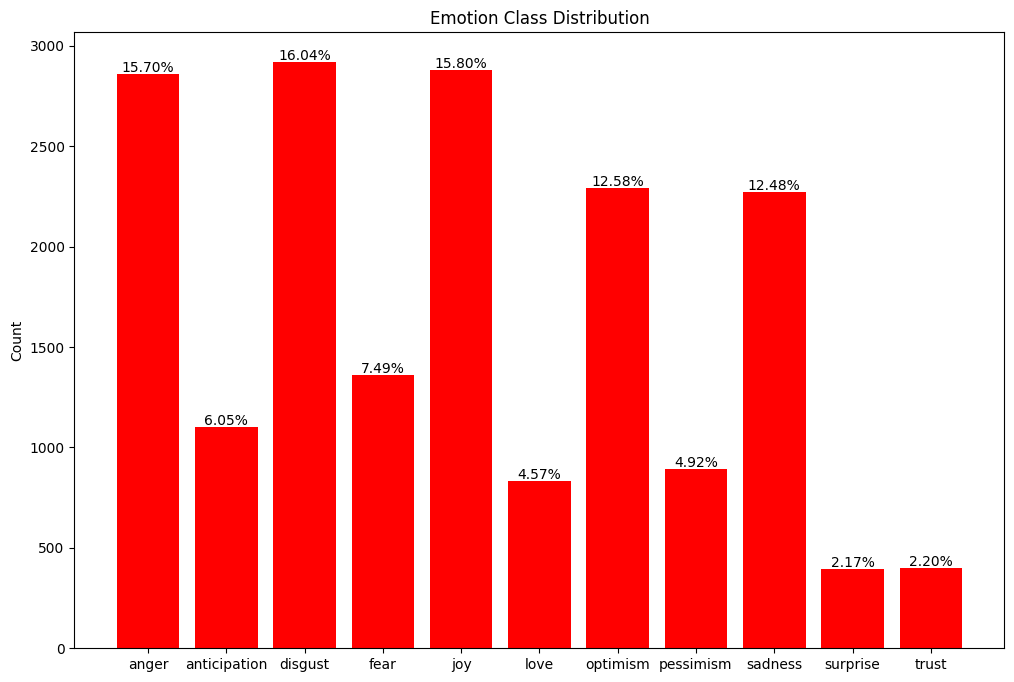

In [11]:
# get the count of each label
label_counts = train_val_labels.sum()

# get the total sum
total_count = label_counts.sum()

# get the percentages
percentages = (label_counts/total_count)*100

# make a bar plot for distribution
plt.figure(figsize = (12, 8))
plt.bar(label_counts.index, label_counts.values, color = 'red')

for i , (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()


In [12]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


# <font color='red'>**3. Manipulate the Splits of the Dataset**

In [13]:
mkf = MultilabelStratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

X = train_valid_df['Tweet'].values
y = train_val_labels.values

for train_index, valid_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[valid_index]
  y_train, y_val = y[train_index], y[valid_index]



In [14]:
train_df = train_valid_df.iloc[train_index] # pulling in the training indices from the split
val_df = train_valid_df.iloc[valid_index] # pulling in the valid indices from the split

In [15]:
train_df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [16]:
val_df.tail()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
7687,2018-03658,That was absolutely the two worst National Ant...,1,0,1,0,0,0,0,1,1,0,0
7693,2018-03875,Everything I order online just comes looking l...,1,0,1,0,0,0,0,0,0,0,0
7698,2018-03846,Some 'friends' get bitter when it seems your l...,0,0,1,0,0,0,0,1,1,0,0
7707,2018-03005,"@ThomasSanders This was great, looking forward...",0,0,0,0,1,0,1,0,0,0,0
7710,2018-01302,@kamaalrkhan Which #chutiya #producer #investe...,1,0,1,0,0,0,0,0,0,0,0


In [17]:
train_labels = train_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

<font color = 'red'>***Plotting the distributions form the training and validation set***

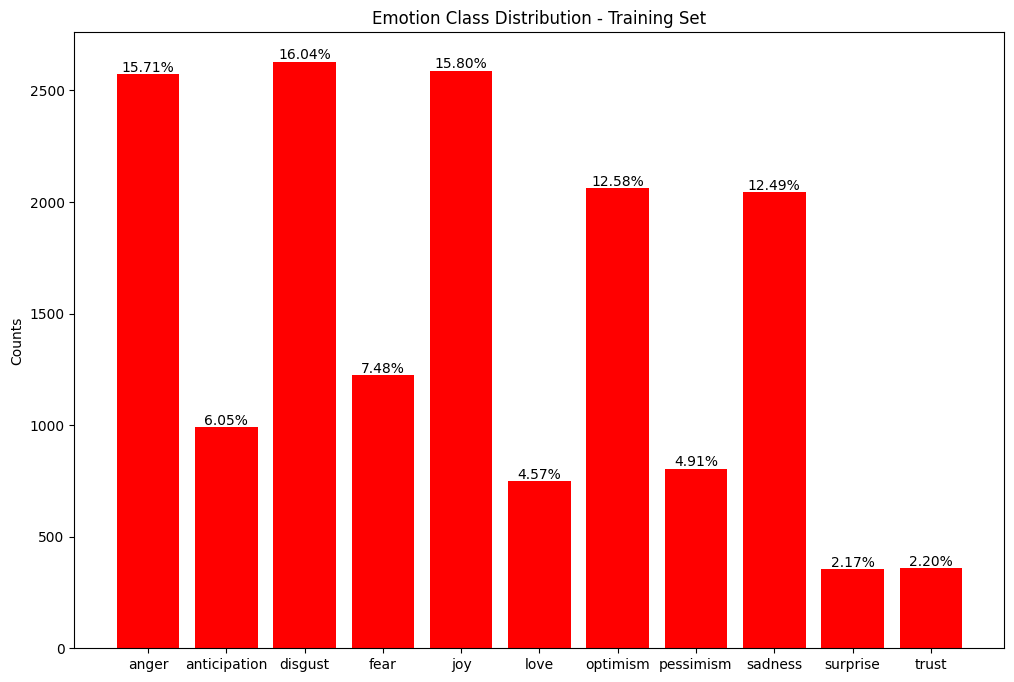

In [18]:
label_counts_t = train_labels.sum()

total_counts_t = label_counts_t.sum()

percentages = (label_counts_t/total_counts_t)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'red')

for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count+10, f'{pct:.2f}%', ha = 'center')

plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Counts')
plt.show()

In [19]:
label_counts_t

,0
anger,2574
anticipation,991
disgust,2629
fear,1226
joy,2589
love,749
optimism,2062
pessimism,805
sadness,2046
surprise,356


In [20]:
val_labels = val_df[['anger',
                         'anticipation',
                         'disgust',
                         'fear',
                         'joy',
                         'love',
                         'optimism',
                         'pessimism',
                         'sadness',
                         'surprise',
                         'trust']]

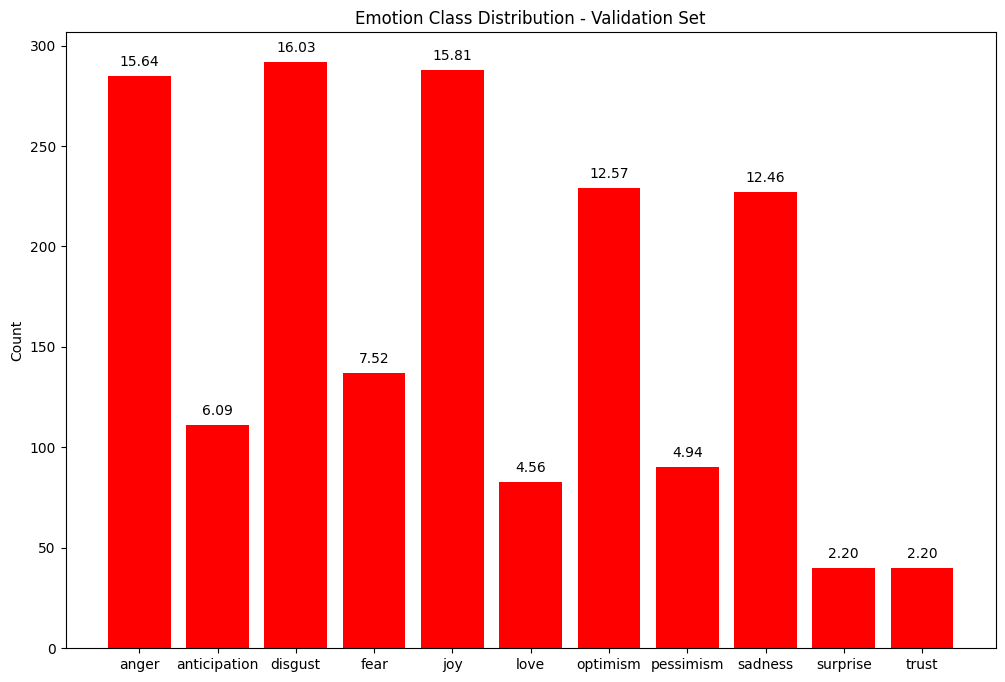

In [21]:
label_counts_v = val_labels.sum()

total_counts_v = label_counts_v.sum()

percentages = (label_counts_v/total_counts_v)*100

plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'red')

for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages)):
  plt.text(i, count+5, f'{pct:.2f}', ha = 'center')

plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

In [22]:
val_labels.sum()

,0
anger,285
anticipation,111
disgust,292
fear,137
joy,288
love,83
optimism,229
pessimism,90
sadness,227
surprise,40


In [23]:
type(X_train)

numpy.ndarray

In [24]:
type(y_train)

numpy.ndarray

In [25]:
X_train = X_train.tolist()
X_val = X_val.tolist()

In [26]:
X_train[0]

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

In [27]:
y_train[0]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [28]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [29]:
# Map the binary array to class names
def map_binary_to_classes(binary_array, class_names):
    # Iterate through each sample (row) in the binary array
    mapped_samples = []
    for sample in binary_array:
        mapped_samples.append([class_names[i] for i in range(len(sample)) if sample[i] == 1])
    return mapped_samples

# Apply the mapping
y_train_mapped = map_binary_to_classes(y_train, class_names)
y_val_mapped = map_binary_to_classes(y_val, class_names)

print(f"Mapped y_train: {y_train_mapped}")
print(f"Mapped y_val: {y_val_mapped}")

Mapped y_train: [['anticipation', 'optimism', 'trust'], ['joy', 'love', 'optimism'], ['anger', 'disgust', 'joy', 'optimism'], ['joy', 'optimism'], ['anger', 'disgust'], ['joy'], ['anger', 'disgust'], ['disgust', 'sadness'], ['anger', 'disgust'], ['disgust', 'pessimism', 'sadness'], [], ['joy', 'love'], ['anger', 'sadness'], ['anger', 'disgust'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust', 'fear'], ['anger', 'disgust', 'joy', 'sadness'], ['joy', 'optimism'], ['anger', 'disgust', 'sadness'], ['anger', 'disgust'], ['fear', 'sadness'], ['joy', 'love', 'optimism'], ['anger', 'disgust'], ['anger', 'disgust', 'fear', 'sadness'], ['joy', 'optimism'], ['anger', 'disgust', 'joy'], ['anger', 'disgust'], ['anger', 'disgust', 'joy', 'optimism'], ['fear', 'joy', 'sadness'], ['anger', 'disgust', 'sadness'], ['joy', 'love', 'optimism'], ['anger', 'disgust'], ['joy', 'optimism'], ['optimism'], [], ['anger', 'disgust', 'joy', 'sadness'], ['optimism', 'sadness'], ['fear'], ['anger', 'disgust'],

<font color = 'red'>***Setting up Datasets for HF trainer***

In [30]:
trainset = Dataset.from_dict({
    'text': X_train,
    'label':y_train_mapped
})

validset = Dataset.from_dict({
    'text':X_val,
    'label':y_val_mapped
})

In [31]:
trainset[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [32]:
validset[0]

{'text': 'Do you think humans have the sense for recognizing impending doom? ',
 'label': ['anticipation', 'pessimism']}

<font color = 'red'>***Final Dataset***

In [33]:
train_val = DatasetDict({
    'train':trainset,
    'valid':validset
})

In [34]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [35]:
train_val['train'][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

In [36]:
train_val['valid'][0]

{'text': 'Do you think humans have the sense for recognizing impending doom? ',
 'label': ['anticipation', 'pessimism']}

# <font color='red'>**4. Load the Pretrained Tokenizer**

## <font color='red'>**The Difference Between a Model with a Classification Head and a Base Decoder for Text Generation**

### **Model Purpose and Architecture**
- **Model with a Classification Head**:
  - **Purpose**: Tailored for tasks requiring **direct label predictions** from a fixed set of categories.
  - **Architecture**:
    - Replaces the **decoder's language head** with a specialized **classification head**.
    - Outputs a probability distribution over predefined labels using a `label2id` or `id2label` mapping.
  - **Use Case**:
    - Ideal for **sequence classification tasks**, such as sentiment analysis, where the output belongs to a fixed label set.
    - Example: Predicting `Positive`, `Negative`, or `Neutral`.

- **Base Decoder for Text Generation**:
  - **Purpose**: Designed to **generate text outputs** by interpreting prompts and context.
  - **Architecture**:
    - Retains the **language head** in the decoder, enabling the generation of free-form text.
    - Accepts a specific prompt and generates outputs token by token.
  - **Use Case**:
    - Best for **flexible and open-ended text generation** tasks, such as summarization or instruction-following.
    - Example: Generating a summary or answering a question based on a prompt.

---

### **Operational Differences**
- **Classification Head**:
  - Input: Preprocessed text.
  - Output: A discrete label from a predefined set.
  - Interaction: Not prompt-driven; relies on training-specific configurations to map text to labels.

- **Base Decoder**:
  - Input: A prompt that specifies the task (e.g., "Summarize the following text:").
  - Output: Text generated based on the given prompt.
  - Interaction: Highly flexible, allowing dynamic task specification through prompts.

---

### **Quantization**
Both approaches can benefit from quantization for efficiency:
- **Definition**: Reduces model precision for memory savings and faster inference.
- **QLoRA (Quantized Low Rank Adaptation)**:
  - Freezes original weights and trains small low-rank matrices for fine-tuning.
  - Effective for both classification and generation tasks.

---

### **Summary**
- **Classification Head Models**:
  - Focus on **direct label predictions** from predefined categories.
  - Replace the decoder's language head with a **classification-specific architecture**.
  - Best for tasks with a **fixed set of outputs**.

- **Base Decoder Models**:
  - Enable **free-form text generation** by interpreting prompts.
  - Retain the decoder's language head, allowing dynamic and flexible text outputs.
  - Suitable for tasks requiring **open-ended responses** or **customized outputs**.

For further optimization and resource efficiency, both models can utilize quantization techniques like **QLoRA**. For additional insights, refer to the [Original QLoRA Paper](https://arxiv.org/abs/2305.14314).


In [37]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")

In [38]:
free_gpu_memory()

GPU memory has been freed.


In [39]:
checkpoint = "Qwen/Qwen2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [40]:
tokenizer.eos_token

'<|endoftext|>'

In [41]:
tokenizer.pad_token

'<|endoftext|>'

In [42]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [43]:
tokenizer.additional_special_tokens

['<|im_start|>',
 '<|im_end|>',
 '<|object_ref_start|>',
 '<|object_ref_end|>',
 '<|box_start|>',
 '<|box_end|>',
 '<|quad_start|>',
 '<|quad_end|>',
 '<|vision_start|>',
 '<|vision_end|>',
 '<|vision_pad|>',
 '<|image_pad|>',
 '<|video_pad|>']

In [44]:
tokenizer.padding_side

'right'

In [45]:
tokenizer.chat_template

'{%- if tools %}\n    {{- \'<|im_start|>system\\n\' }}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- messages[0][\'content\'] }}\n    {%- else %}\n        {{- \'You are a helpful assistant.\' }}\n    {%- endif %}\n    {{- "\\n\\n# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>" }}\n    {%- for tool in tools %}\n        {{- "\\n" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- "\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\"name\\": <function-name>, \\"arguments\\": <args-json-object>}\\n</tool_call><|im_end|>\\n" }}\n{%- else %}\n    {%- if messages[0][\'role\'] == \'system\' %}\n        {{- \'<|im_start|>system\\n\' + messages[0][\'content\'] + \'<|im_end|>\\n\' }}\n    {%- else %}\n        {{- \'<|im_start|>system\\nYou are a he

# <font color='red'>**5. Creating Prompts**

In [46]:
def formatting_prompts_func(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """Format a single example or batch of examples"""
    # Debug the input type
    # print("Input type:", type(examples))
    # print("Input content:", examples)

    # Convert to dict if it's a LazyRow
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example case (for dataset.map)
    if isinstance(examples, dict):
        if not isinstance(examples[input_field], (list, tuple)):
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Handle batch case
            output_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token
                prompt = prompt.strip()
                output_prompts.append(prompt)

            return output_prompts

    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary with examples, got {type(examples)}")

In [47]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"].\
 ### TEXT: {} {} {}'

In [48]:
output_delimiter = '### LABEL:'
input_field = 'text'
output_field = 'label'

In [49]:
output_delimiter

'### LABEL:'

In [50]:
# importing the partial library to freeze values within a function
from functools import partial

In [51]:
formatting_prompts_func_final = partial(formatting_prompts_func, # function that will have froze values
                                       input_field = input_field, # freezing the input_field
                                       output_field = output_field, # freezing the output_field
                                       prompt_template = prompt_template, #freezing the prompt_template
                                       output_delimiter = output_delimiter, # freezing the output_delimiter
                                       tokenizer = tokenizer) # freezing the tokenizer

In [52]:
sample = formatting_prompts_func_final(train_val['train'][0:3])

In [53]:
from pprint import pprint
pprint(sample[2], width = 120)

('Classify the TEXT by selecting all applicable labels from the following list: '
 '["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"]. ### '
 "TEXT: @Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling "
 "was wow, ! #GOPATS ### LABEL: ['anger', 'disgust', 'joy', 'optimism']<|endoftext|>")


<font color = 'red'>***Prompt Formatting correct***

## <font color = 'red'>**5.1 Filtering Long Sequences**

In [54]:
def filter_by_length(example, max_length, tokenizer, prompt_function):
    """Filter a single example based on length"""
    # Convert LazyRow to dict if needed
    example_dict = dict(example) if hasattr(example, 'keys') else example

    prompt = prompt_function(example_dict)  # handles single example
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])
    example['keep'] = total_length <= max_length
    return example

# Create partial function
filter_fn = partial(filter_by_length,
                   max_length=1000,
                   tokenizer=tokenizer,
                   prompt_function=formatting_prompts_func_final)

# Now try processing the dataset
train_val_subset = train_val.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/6951 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/773 [00:00<?, ? examples/s]

In [73]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 773
    })
})

In [74]:
train_val_subset['train'][:5]

{'text': ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
  'Whatever you decide to do make sure it makes you #happy.',
  "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
  "Accept the challenges so that you can literally even feel the exhilaration of victory.' -- George S. Patton 🐶",
  "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"],
 'label': [['anticipation', 'optimism', 'trust'],
  ['joy', 'love', 'optimism'],
  ['anger', 'disgust', 'joy', 'optimism'],
  ['joy', 'optimism'],
  ['anger', 'disgust']],
 'keep': [True, True, True, True, True]}

In [75]:
train_val_subset_filtered = train_val_subset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/6951 [00:00<?, ? examples/s]

Filter:   0%|          | 0/773 [00:00<?, ? examples/s]

In [76]:
train_val_subset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [137]:
train_val_subset_filtered['train'][0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': ['anticipation', 'optimism', 'trust']}

## <font color = 'red'>**5.2 Data Collator**

## `get_token_ids_in_context` Function

### **Purpose**
This function extracts the token IDs for a specific substring within a larger string by mapping character indices in the text to token indices using a tokenizer.

---

### **Parameters**
- `tokenizer`: A tokenizer object (e.g., from Hugging Face) to tokenize the input strings.
- `full_string` (str): The complete text to tokenize.
- `substring` (str): The specific portion of `full_string` for which token IDs are required.

---

### **Detailed Explanation of Token Index Mapping**
1. **Identify Substring Character Positions**:
   - Find the start (`start_index`) and end (`end_index`) character positions of the `substring` within the `full_string`.

2. **Tokenize up to Start and End**:
   - Tokenize the text from the beginning of `full_string` to `start_index` and `end_index` separately.
   - The number of tokens generated for these slices determines the token indices corresponding to the `substring`.

3. **Adjust for Token Boundaries**:
   - Start token index: Take one token earlier (if possible) to include the starting boundary of the `substring`.
   - End token index: Corresponds to the tokens generated for the slice up to `end_index`.

4. **Extract Token IDs**:
   - Using the token indices, slice the full list of token IDs and return the relevant ones for the `substring`.

---

### **Example**
#### Inputs:
```python
full_string = "This is an example sentence."
substring = "example"
```
### Step 1:
 The tokenizer generates token IDs for the entire full_string.

 Lets say the token IDs [1,2,3,4,5,6] correspond to the words ['This','is','an','example','sentence']

We use the tokenizer to map the words to these tokens.

### Step 2:

- Locate the substring 'example' in the full string.
  - start_index would be the index within the full string that lines up with the first letter in example, in our case it is 11.
  - end_index is going to be the start_index plus the length of the substring to get the ending index of the last letter of the substring within the full string.

### Step 3:

- We will tokenize the portion of the full string up to the start index of the substring. In our case we would tokenize all words before example 'This','is','an'
- Then we tokenize up to the end of the substring to include 'example' in the tokenization.

### Step 4:
- Now we use the token indices to slice the full list of tokens [1,2,3,4,5,6]
  - Then we pull the tokens that correspond to the substring which in our case are [3,4]


In [77]:
def get_token_ids_in_context(tokenizer, full_string, substring):
  # Tokenize the full string
  full_tokens = tokenizer.encode(full_string, add_special_tokens = False) # Do not add special tokens

  # finding the start and end index of the substring in the full string
  start_index = full_string.index(substring)
  end_index = start_index+len(substring)

  # Find the corresponding tokens, starting one token earlier to include the initial token
  start_token_index = max(0, len(tokenizer.encode(full_string[:start_index], add_special_tokens = False)) -1)
  end_token_index = len(tokenizer.encode(full_string[:end_index], add_special_tokens = False))

  return full_tokens[start_token_index:end_token_index]

In [78]:
# Create a sample prompt format
sample_prompt_format = 'some text {} {} {}'

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")

output_delimiter_ids = get_token_ids_in_context(tokenizer, full_string = sample_prompt, substring = output_delimiter)

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

Original output_delimiter: ### LABEL:
output_delimiter_ids: [16600, 56874, 25]
Delimiter tokens: ['Ġ###', 'ĠLABEL', ':']
Reconstructed output_delimiter:  ### LABEL:


In [79]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer = tokenizer, mlm = False,
                                                     response_template = output_delimiter_ids)



<font color = 'red'>***Now the response template is the token '### LABEL' which is in our mapped prompt within the dataset.***

# <font color='red'>**6. Train the Model**

## <font color='red'>**6.1 Download the Model**

In [80]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [81]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [82]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [83]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


## <font color='red'>**6.2 PEFT Setup**

In [84]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear4bit(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)


In [85]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [86]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['k_proj',
 'gate_proj',
 'q_proj',
 'up_proj',
 'lm_head',
 'o_proj',
 'v_proj',
 'down_proj']

In [87]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [88]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 147,718,144 || all params: 1,691,432,448 || trainable%: 8.7333


## <font color='red'>**6.3 Define Training Arguments**

In [89]:
run_name = 'QWEN-2.5-1.5B-base-decoder-exp1'
use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)

In [90]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

Qwen2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2.5-1.5B",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 131072,
  "max_window_layers": 28,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps

## <font color='red'>**6.4 Instantiate the Trainer**

In [91]:
# lora_model.config.use_cache = False
trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_subset_filtered['train'],
        eval_dataset=train_val_subset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

## <font color='red'>**6.5 Setup Weights & Biases (WANDB)**

In [92]:
%env WANDB_PROJECT = multilabel_emotion_qwen_decoder

env: WANDB_PROJECT=multilabel_emotion_qwen_decoder


## <font color='red'>**6.6 Training and Validation**

In [93]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e

Step,Training Loss,Validation Loss
50,0.454100,0.376601
100,0.364900,0.352500
150,0.358000,0.341841
200,0.344100,0.337665
250,0.324900,0.341892
300,0.293000,0.339676
350,0.293800,0.334610
400,0.290900,0.339108
450,0.274000,0.340145
500,0.231900,0.357184


In [94]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [95]:
best_model_checkpoint_step

'350'

In [96]:
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/QWEN-2.5-1.5B_base_model/checkpoint-350'

In [97]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [98]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

In [99]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side='left'
tokenizer.pad_token

'<|endoftext|>'

In [100]:
print(output_delimiter)

### LABEL:


In [101]:
free_gpu_memory()

GPU memory has been freed.


## <font color='red'>**6.7 Generate Labels Using the Instruction-Tuned Language Head**

# Function Documentation: `run_inference_instruction`

## Purpose
The `run_inference_instruction` function is designed to perform inference using a language model on a dataset. It processes text inputs in batches, generates outputs based on model predictions, and provides a structured result that includes the input text, the model's output, and (optionally) the ground truth labels. The function supports saving these results to a file for further analysis or debugging.

---

## Parameters

| **Parameter**              | **Type**               | **Description**                                                                                     |
|----------------------------|------------------------|-----------------------------------------------------------------------------------------------------|
| `seed`                     | `int`                 | Random seed to ensure reproducibility of the results.                                               |
| `dataset`                  | `Union[Dict, List]`   | Input dataset, where each element is a dictionary or object containing input text and (optionally) expected outputs. |
| `model`                    | Model object          | The language model used for generating predictions.                                                 |
| `tokenizer`                | Tokenizer object      | Tokenizer used to preprocess the input text into model-readable format.                            |
| `per_device_batch_size`    | `int`                 | Number of samples processed per batch during inference.                                            |
| `input_field`              | `str`                 | Name of the field in the dataset containing input text.                                             |
| `output_field`             | `str`                 | Name of the field in the dataset containing expected outputs (ground truth).                        |
| `save_dir`                 | `Optional[Path]`      | Directory where the generated outputs will be saved.                                                |
| `save_file_name`           | `Optional[str]`       | Name of the file for saving the results. If not specified, a timestamped filename is generated.     |
| `max_new_tokens`           | `int`                 | Maximum number of new tokens the model can generate per input. Default is 20.                      |
| `num_beams`                | `int`                 | Number of beams for beam search. Higher values improve result diversity but increase computation cost. |
| `do_sample`                | `bool`                | Whether to use sampling for generation instead of deterministic decoding. Default is `False`.       |
| `top_k`                    | `int`                 | Limits sampling to the top `k` most likely tokens. Used when `do_sample` is `True`.                 |
| `top_p`                    | `float`               | Nucleus sampling: considers only the smallest set of tokens whose cumulative probability exceeds `top_p`. |
| `temperature`              | `float`               | Adjusts the randomness of predictions. Lower values make results more deterministic, while higher values add diversity. |
| `no_repeat_ngram_size`     | `int`                 | Prevents repetition of n-grams of this size in the generated output, improving coherence.            |
| `num_return_sequences`     | `int`                 | Number of sequences to return for each input. Default is 1.                                         |

---

## Returns
A list of dictionaries, each containing:
- **`input`**: The original input text.
- **`generated_output`**: The text generated by the model.
- **`ground_truth`**: The expected output (if available) from the dataset or `'N/A'` if not provided.

---

## Function Workflow

### 1. **Setup**
- **Seed Initialization**: Sets the random seed using the `set_seed()` function for reproducible results.
- **Model Configuration**: Puts the model into evaluation mode using `model.eval()` and determines the appropriate computing device (e.g., GPU or CPU).
- **Batch Size**: Configures the number of samples to process at a time (`per_device_batch_size`).

### 2. **Batch Processing**
- Iterates over the dataset in batches, determined by `per_device_batch_size`.
- For each batch:
  1. Extracts the input text using the specified `input_field`.
  2. Extracts the ground truth (if available) using `output_field`; defaults to `'N/A'` if the field is not present.
  3. Tokenizes the input text using the provided tokenizer and converts it into PyTorch tensors, padding as necessary for uniform input length.
  4. Moves the tensors to the computing device (e.g., GPU).

### 3. **Generation**
- Performs inference using the `model.generate()` method, applying parameters such as:
  - **`max_new_tokens`**: Controls the maximum length of the generated text.
  - **`num_beams`**: Determines the number of beams for beam search to balance diversity and quality.
  - **`do_sample`**: Enables sampling for stochastic outputs if set to `True`.
  - **`top_k` and `top_p`**: Manage token selection probabilities when sampling.
  - **`temperature`**: Adjusts the "sharpness" of token probabilities.
  - **`no_repeat_ngram_size`**: Prevents repetitive patterns in the output.
- Decodes the generated tokens back into readable text using `tokenizer.batch_decode()`.

### 4. **Result Compilation**
- Constructs a dictionary for each input containing:
  - Input text.
  - Generated output.
  - Ground truth labels (if available).
- Appends the dictionary to the `inference_results` list.

### 5. **Error Handling**
- Captures and logs any errors during batch processing, ensuring the function continues processing subsequent batches.

### 6. **Saving Results (Optional)**
- If `save_dir` is specified:
  - Creates the directory (if it doesn't exist).
  - Saves the results as a JSON file, with the name either provided by `save_file_name` or generated using the current timestamp.

### 7. **Return**
- Returns the `inference_results` list, which contains all the inputs, generated outputs, and ground truth labels.



In [102]:
def run_inference(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    prompt_template: str,
    input_field: str,
    output_field: str,
    output_delimiter: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 10,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:
    """
    Run inference on a dataset and return complete generations.

    Args:
        seed (int): Random seed for reproducibility
        dataset (Union[Dict, List]): Input dataset containing text to generate from
        model: Pre-trained model to use for inference
        tokenizer: Tokenizer associated with the model
        per_device_batch_size (int): Number of samples to process in each batch
        input_field (str): Key name for accessing input text in the dataset
        output_delimiter: Delimiter used in prompt template
        output_field (str): Key name for accessing ground truth labels in the dataset
        save_dir (Optional[Path]): Directory path to save generation results. If None, results won't be saved
        save_file_name (Optional[str]): Name of the file to save results. If None, uses timestamp
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 10
        num_beams (int, optional): Number of beams for beam search. Defaults to 1
        do_sample (bool, optional): Whether to use sampling. Defaults to False
        top_k (int, optional): Number of highest probability tokens to keep for top-k sampling. Defaults to 50
        top_p (float, optional): Cumulative probability cutoff for top-p sampling. Defaults to 1.0
        temperature (float, optional): Sampling temperature; higher means more random. Defaults to 1.0
        no_repeat_ngram_size (int, optional): Size of n-grams to prevent repetition. Defaults to 2
        num_return_sequences (int, optional): Number of sequences to generate per input. Defaults to 1

    Returns:
        List[Dict]: List of dictionaries containing:
          - "input": Original input text
          - "generated_output": Model-generated text
          - "ground_truth": Ground truth label if available, "N/A" if not
    """
    set_seed(seed)
    model.eval()
    print(f"Model device for inference: {model.device}")
    device = model.device
    batch_size = per_device_batch_size

    inference_results = []

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating responses")

    for i in progress_bar:
        # Create a batch
        batch = dataset[i:i + batch_size]

        try:
            texts = batch[input_field]
            labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)
            prompts = [prompt_template.format(text.strip(), output_delimiter.strip(), "").strip() for text in texts]
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    do_sample=do_sample,
                    top_k=top_k,
                    top_p=top_p,
                    temperature=temperature,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    num_return_sequences=num_return_sequences,
                    pad_token_id=tokenizer.pad_token_id,
                )

            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })

            continue

        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            print(f"Problematic batch: {batch}")
            continue

    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [103]:
valid_inference_results = run_inference(seed = 42,
              dataset=train_val_subset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations_qwen_base')

Model device for inference: cuda:0


Generating responses: 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]

Saved inference_results to: /content/drive/MyDrive/Colab Notebooks/models/nlp_fall_2024/QWEN-2.5-1.5B_base_model/valid_complete_generations_qwen_base.json


In [104]:
file_name = model_folder/'valid_complete_generations_qwen_base.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [105]:
valid_inference_results[0]

{'input': 'Do you think humans have the sense for recognizing impending doom? ',
 'generated_output': 'Classify the TEXT by selecting all applicable labels from the following list: ["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"]. ### TEXT: Do you think humans have the sense for recognizing impending doom? ### LABEL: [\'anticipate\', \'fears\', ]',
 'ground_truth': ['anticipation', 'pessimism']}

In [106]:
valid_inference_results[1]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"]. ### TEXT: What a fucking muppet.  @jRwild1  #stalker. ### LABEL: [\'anger\', \'disagreement\', ]'

In [107]:
valid_inference_results[2]['generated_output']

'Classify the TEXT by selecting all applicable labels from the following list: ["anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust"]. ### TEXT: @FaithHill I remember it well #happy #afraid #Positive ### LABEL: [\'fears\', \'joy\', [\'love\','

In [108]:
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*)'
    match = re.search(pattern, generated_output, re.DOTALL)
    return match.group(1).strip() if match else None

In [109]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [110]:
valid_extracted_outputs[0]

"['anticipate', 'fears', ]"

In [111]:
for i in range(20):
  print(valid_extracted_outputs[i])

['anticipate', 'fears', ]
['anger', 'disagreement', ]
['fears', 'joy', ['love',
['fears', 'optimistic']
['anger', 'disagreement',
['anger', 'optimistic', ]
['anger', 'anticipate', ]
['anticipate', 'joy', ]
['joy']
['sad']
['joy', 'love', "optimistic"]
['anger', 'disagreement', ]
['anticipate', 'joy', ]
['anticipate', 'dislike', ]
['joy', 'optimistic']
['anger', 'disagreement',
['fright', 'joy']
['anger', 'disagreement',
['joy', 'love', "sad", '
['joy', 'optimistic']


In [112]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

['anticipation', 'pessimism']
['anger', 'disgust']
['fear', 'joy', 'love', 'optimism']
['anger', 'disgust', 'fear']
['disgust', 'fear', 'optimism', 'trust']
['anger', 'optimism']
['anger']
['joy', 'optimism']
['joy', 'optimism']
['sadness']
['joy', 'love']
['anger', 'disgust', 'sadness']
['anticipation', 'joy', 'optimism', 'surprise']
['anticipation']
['anger', 'anticipation', 'disgust', 'optimism']
['anger', 'disgust', 'joy', 'optimism']
['anger', 'disgust', 'fear']
['anger', 'disgust', 'pessimism']
['joy', 'love', 'sadness']
['anticipation', 'joy', 'optimism']


In [113]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels


In [114]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['anticipation', 'pessimism'], ['anger', 'disgust'], ['fear', 'joy', 'love', 'optimism'], ['anger', 'disgust', 'fear'], ['disgust', 'fear', 'optimism', 'trust']]
Sample of predictions: [['anticipation', 'fear'], ['anger'], ['fear', 'joy', 'love'], ['fear', 'optimism'], ['anger']]

Binary format:
Labels shape: (773, 11)
Predictions shape: (773, 11)


In [115]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [116]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [117]:
valid_metrics

{'f1_micro': 0.5739586749754018,
 'f1_macro': 0.4340837347108976,
 'accuracy_label': 0.8472303892743738,
 'accuracy_all': 0.1500646830530401}

In [118]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

In [119]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[422  66]
  [ 38 247]]

 [[607  55]
  [ 64  47]]

 [[480   1]
  [288   4]]

 [[628   8]
  [103  34]]

 [[400  85]
  [ 36 252]]

 [[661  29]
  [ 35  48]]

 [[481  63]
  [ 92 137]]

 [[677   6]
  [ 75  15]]

 [[516  30]
  [143  84]]

 [[730   3]
  [ 36   4]]

 [[727   6]
  [ 37   3]]]


In [124]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Reds',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Reds')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

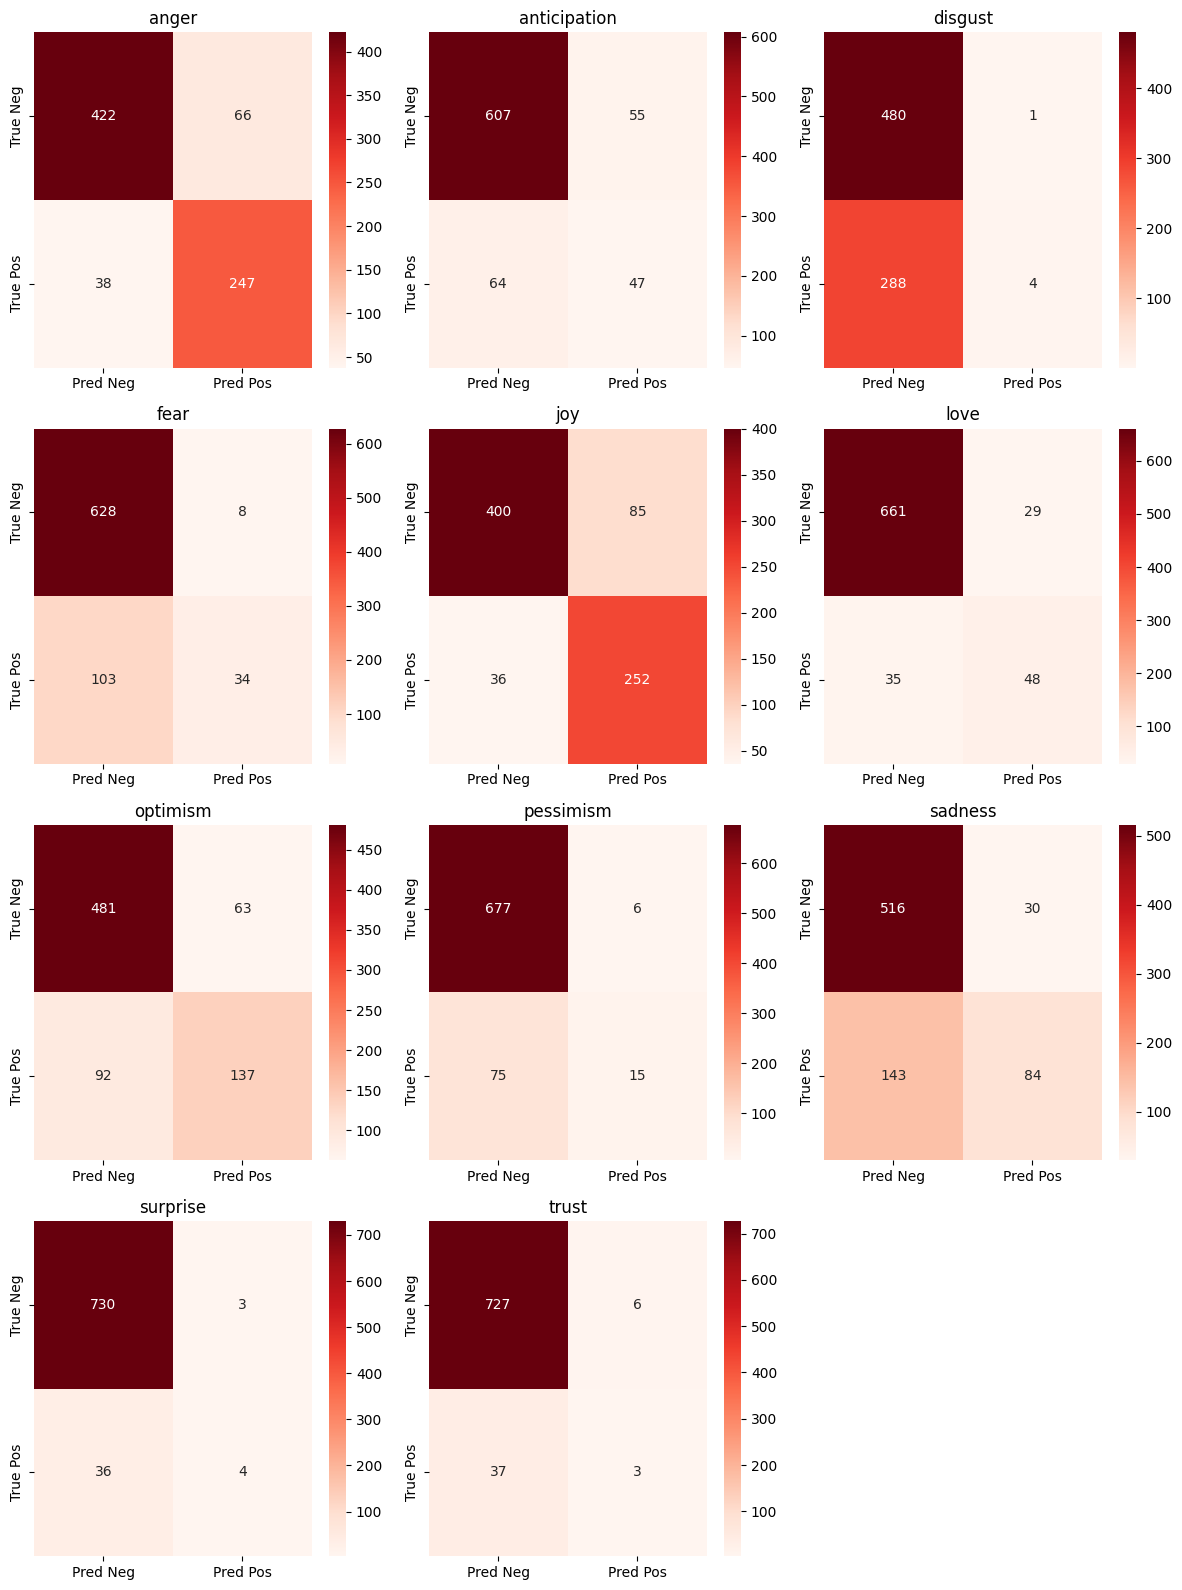

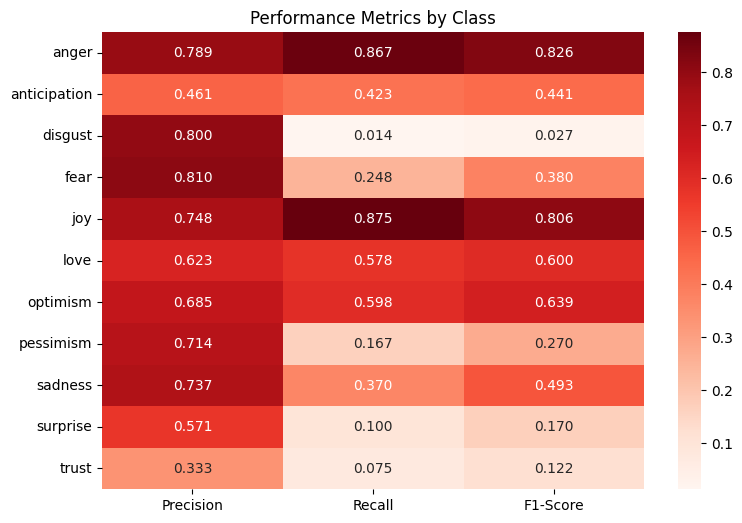

<Figure size 1200x533.333 with 0 Axes>

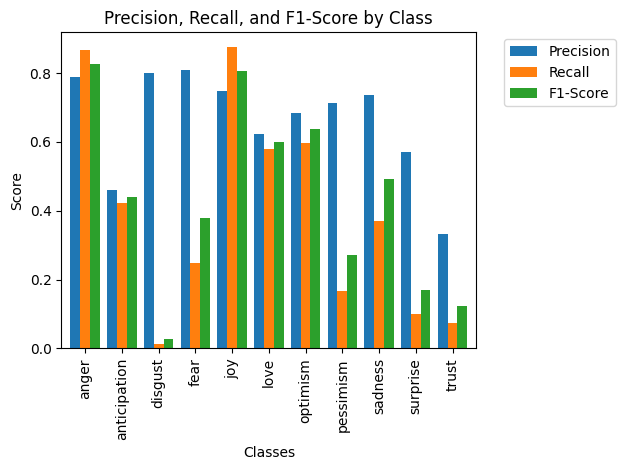

{'macro_avg': {'precision': 0.6610442119855053,
  'recall': 0.3922946500327409,
  'f1': 0.4340837347108976},
 'per_class': {'Precision': {'anger': 0.7891373801916933,
   'anticipation': 0.46078431372549017,
   'disgust': 0.8,
   'fear': 0.8095238095238095,
   'joy': 0.7477744807121661,
   'love': 0.6233766233766234,
   'optimism': 0.685,
   'pessimism': 0.7142857142857143,
   'sadness': 0.7368421052631579,
   'surprise': 0.5714285714285714,
   'trust': 0.3333333333333333},
  'Recall': {'anger': 0.8666666666666667,
   'anticipation': 0.42342342342342343,
   'disgust': 0.0136986301369863,
   'fear': 0.24817518248175183,
   'joy': 0.875,
   'love': 0.5783132530120482,
   'optimism': 0.5982532751091703,
   'pessimism': 0.16666666666666666,
   'sadness': 0.3700440528634361,
   'surprise': 0.1,
   'trust': 0.075},
  'F1-Score': {'anger': 0.8260869565217391,
   'anticipation': 0.4413145539906103,
   'disgust': 0.026936026936026935,
   'fear': 0.37988826815642457,
   'joy': 0.8064,
   'love': 

In [125]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

In [126]:
wandb.finish()

eval/loss,█▄▂▂▂▂▁▂▂▅▆▆▆
eval/runtime,▃▆▁▅▂▄▆▄▁▅▅█▄
eval/samples_per_second,▆▃█▄▇▅▃▅█▄▄▁▅
eval/steps_per_second,▆▃█▄▇▅▃▅█▄▄▁▅
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇███
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇████
train/grad_norm,█▆▃▂▆▃▃▄▁▃▃▆▅
train/learning_rate,█▇▇▆▆▅▅▄▃▃▂▂▁
train/loss,█▅▅▅▄▃▃▃▂▁▁▁▁
valid_f1_macro,▁
eval/loss,0.36164


# <font color='red'>**7. Model Inference**

In [138]:
# loading in the test data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [139]:
test_df = pd.DataFrame(test_ds).T # transposing
test_df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print("-"*30)
print(test_df.shape)
print('There are no labels for the entire test set.')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no labels for the entire test set.


In [140]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


In [141]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the dataset

In [142]:
import random

In [143]:
# Function to assign random non-duplicate labels to each text
def assign_random_labels(class_names, max_labels=3):
    """Assign a random subset of non-duplicate labels."""
    num_labels = random.randint(1, max_labels)  # Randomly decide how many labels to assign
    return random.sample(class_names, num_labels)

test_ds['label'] = [assign_random_labels(class_names) for _ in range(len(test_ds))]


In [144]:
test_ds

,text,label
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,"[fear, love]"
1,"Academy of Sciences, eschews the normally sobe...",[surprise]
2,I blew that opportunity -__- #mad,[fear]
3,This time in 2 weeks I will be 30... 😥,"[optimism, anticipation, fear]"
4,#Deppression is real. Partners w/ #depressed p...,[disgust]
...,...,...
3254,shaft abrasions from panties merely shifted to...,"[sadness, surprise, love]"
3255,@lomadia heard of Remothered? Indie horror gam...,"[disgust, surprise]"
3256,All this fake outrage. Y'all need to stop 🤣,"[trust, surprise, fear]"
3257,Would be ever so grateful if you could record ...,"[optimism, disgust]"


In [145]:
test_ds = Dataset.from_pandas(test_ds)

In [146]:
test_ds['text'][:5]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad',
 'This time in 2 weeks I will be 30... 😥',
 '#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse']

In [147]:
test_ds['label'][:5]

[['fear', 'love'],
 ['surprise'],
 ['fear'],
 ['optimism', 'anticipation', 'fear'],
 ['disgust']]

In [148]:
test_ds = test_ds.map(filter_fn, desc = 'Processing dataset')

Processing dataset:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [149]:
test_ds_filtered = test_ds.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [150]:
free_gpu_memory()

GPU memory has been freed.


In [151]:

model_folder = base_folder/'models/nlp_fall_2024/QWEN-2.5-1.5B_base_model'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.padding_side='left'
tokenizer.pad_token

'<|endoftext|>'

In [152]:
inference_results= run_inference(seed = 42,
              dataset=test_ds_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Model device for inference: cuda:0


Generating responses: 100%|██████████| 82/82 [01:59<00:00,  1.46s/it]


In [153]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs

]

In [154]:
predictions[:5]

[['anger'], [], ['anger'], ['anticipation', 'joy', 'sadness'], ['fear']]

In [155]:
def get_prediction_labels(predictions, class_names, df_test_ids):
  """
  This function processes the pipeline output of generated model labels and generates the binary predictions for each observation.
  The predictions are binarized based on the presence of each label in the pipeline output for the test set.

  Parameters:
  - predictions: The output from the model inference. (A list of lists containing the labels for each observation)
  - class_names: The emotion class names from the given dataset.
  - df_test_ids: A dataframe that containing the ID's as the primary key for the test set. (Contains an 'ID' column)

  Returns:
  - df_pred_final: A pandas DataFrame with the appropriate test ID linked with its binary predictions.
  """

  # 1. Prepare the binary predictions (1 if the label was predicted else 0)
  binary_predictions = [] # empty list for the predictions
  for pred_set in predictions:
    # Intitialize a list of 0's for each class.
    binary_preds = [1 if class_name in pred_set else 0 for class_name in class_names]
    binary_predictions.append(binary_preds)

  # 2. Convert the binary predictions to a DataFrame
  df_predictions = pd.DataFrame(binary_predictions, columns = class_names)

  # 3. Concatenate the ID's to the dataframe
  df_pred_final = pd.concat([df_test_ids.reset_index(drop=True), df_predictions], axis=1)

  # 4. Set the index of df_pred_final to be the ID column
  df_pred_final = df_pred_final.set_index('ID')

  return df_pred_final

In [156]:
df_pred_final = get_prediction_labels(predictions, class_names, test_ids)

In [157]:
df_pred_final.sum()

,0
anger,1136
anticipation,263
disgust,12
fear,173
joy,1632
love,454
optimism,1101
pessimism,72
sadness,610
surprise,44


In [158]:
df_pred_final.shape

(3259, 11)

In [159]:
df_pred_final.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
ID,,,,,,,,,,,
2018-01559,1,0,0,0,0,0,0,0,0,0,0
2018-03739,0,0,0,0,0,0,0,0,0,0,0
2018-00385,1,0,0,0,0,0,0,0,0,0,0
2018-03001,0,1,0,0,1,0,0,0,1,0,0
2018-01988,0,0,0,1,0,0,0,0,0,0,0


In [160]:
df_pred_final.to_csv(base_folder/'predictions_qwen_decoder_base.csv')